<a href="https://colab.research.google.com/github/Namtk214/RNN-LSTM-GRU/blob/main/RNN_for_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [2]:
!gdown 178YSDYmlRh54IcxStgYA3UyKFRM9-3DO

Downloading...
From: https://drive.google.com/uc?id=178YSDYmlRh54IcxStgYA3UyKFRM9-3DO
To: /content/dataset.zip
100% 2.35M/2.35M [00:00<00:00, 169MB/s]


In [3]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
   creating: dataset/
  inflating: dataset/weatherHistory.csv  


In [39]:
dataset_filepath = 'dataset/weatherHistory.csv'
df = pd.read_csv(dataset_filepath)
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [42]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']
univariate_df.head()

,Temperature (C)
Formatted Date,
2006-04-01 00:00:00.000 +0200,9.472222
2006-04-01 01:00:00.000 +0200,9.355556
2006-04-01 02:00:00.000 +0200,9.377778
2006-04-01 03:00:00.000 +0200,8.288889
2006-04-01 04:00:00.000 +0200,8.755556


Slicing window

In [44]:
# input_size = 6
# label_size = 1
# offset = 1
# start_idx = 0
# end_idx = 1

# def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
#     features = []
#     labels = []  # Initialize labels as a list

#     window_size = input_size + offset
#     if df_end_idx == None:
#         df_end_idx = len(df) - offset
#     #df_end_idx = min(df_end_idx, len(df) - window_size + 1)
#     for idx in range(df_start_idx, df_end_idx):
#         feature_end_idx = idx + input_size
#         label_start_idx = idx + window_size - label_size

#         feature = df[idx:feature_end_idx]#.values.tolist()
#         # Append the label value to the labels list instead of extending
#         label = df[label_start_idx:(idx + window_size)]#.values.tolist()[-1]

#         labels.append(label)  # Append the single label value
#         features.append(feature)

#     features = np.expand_dims(np.array(features), -1)
#     labels = np.array(labels)

#     return features, labels

# X, y = slicing_window(univariate_df, start_idx, end_idx, input_size, label_size, offset)
# X, y


(array([[[9.47222222],
         [9.35555556],
         [9.37777778],
         [8.28888889],
         [8.75555556],
         [9.22222222]]]),
 array([[7.73333333]]))

In [49]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []

    window_size = input_size + offset

    if df_end_idx == None:
        df_end_idx = len(df) - window_size

    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size

        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx+window_size)]

        features.append(feature)
        labels.append(label)

    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)

    return features, labels

In [50]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(univariate_df, 0, train_end_idx, input_size, label_size, offset)
X_val, y_val = slicing_window(univariate_df, train_end_idx, val_end_idx, input_size, label_size, offset)
X_test, y_test = slicing_window(univariate_df, val_end_idx, None, input_size, label_size, offset)

In [52]:
class WeatherForcast(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y


In [53]:
train_dataset = WeatherForcast(X_train, y_train)
val_dataset = WeatherForcast(X_val, y_val)
test_dataset = WeatherForcast(X_test, y_test)

train_batch_size = 128
test_batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [54]:
class WeatherForcastor(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        super(WeatherForcastor, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x, _ = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [55]:
embedding_dim = 1
hidden_size = 8
n_layers = 1
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForcastor(embedding_dim, hidden_size, n_layers, dropout_prob).to(device)


In [56]:
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [57]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            #_, predicted = torch.max(outputs.data, 1)
            predicted = outputs.round()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss = np.mean(losses)
    acc = correct / total
    return loss, acc

In [58]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, device):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())

        train_loss = np.mean(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_losses, val_losses



In [59]:
train_losses, val_losses = fit(model, train_dataloader, val_dataloader, epochs, criterion, optimizer, device)

Epoch: 1/50, Train Loss: 148.8157, Val Loss: 55.6133, Val Acc: 0.0022
Epoch: 2/50, Train Loss: 35.6056, Val Loss: 8.6199, Val Acc: 0.0044
Epoch: 3/50, Train Loss: 15.8645, Val Loss: 3.7198, Val Acc: 0.0041
Epoch: 4/50, Train Loss: 12.4911, Val Loss: 2.8620, Val Acc: 0.0037
Epoch: 5/50, Train Loss: 11.2798, Val Loss: 2.3964, Val Acc: 0.0038
Epoch: 6/50, Train Loss: 10.5559, Val Loss: 2.2051, Val Acc: 0.0038
Epoch: 7/50, Train Loss: 9.8833, Val Loss: 1.9014, Val Acc: 0.0043
Epoch: 8/50, Train Loss: 9.6630, Val Loss: 2.1954, Val Acc: 0.0036
Epoch: 9/50, Train Loss: 9.4577, Val Loss: 2.1010, Val Acc: 0.0035
Epoch: 10/50, Train Loss: 9.2155, Val Loss: 1.6791, Val Acc: 0.0046
Epoch: 11/50, Train Loss: 8.9772, Val Loss: 1.8699, Val Acc: 0.0038
Epoch: 12/50, Train Loss: 8.7243, Val Loss: 1.8818, Val Acc: 0.0039
Epoch: 13/50, Train Loss: 8.4568, Val Loss: 1.8496, Val Acc: 0.0038
Epoch: 14/50, Train Loss: 8.3488, Val Loss: 1.6173, Val Acc: 0.0046
Epoch: 15/50, Train Loss: 8.1324, Val Loss: 1.781

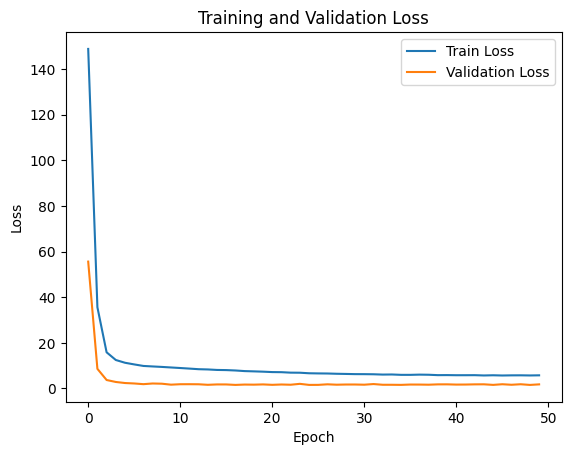

In [60]:

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [61]:
val_loss, val_acc = evaluate(model, val_dataloader, criterion, device)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Validation Loss: 1.8084, Validation Accuracy: 0.0030
Test Loss: 1.6716, Test Accuracy: 0.0032


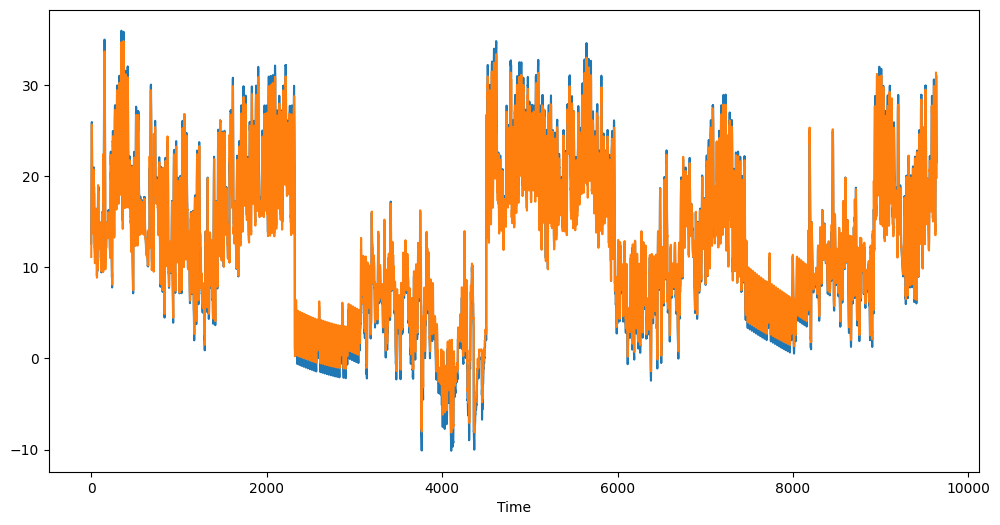

In [62]:
def plot_difference(y, pred):
    plt.figure(figsize=(12, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()
    plt.plot(times, y_to_plot, label='Actual')
    plt.plot(times, pred_to_plot, label='Predicted')
    plt.xlabel('Time')

inputs = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    pred = model(inputs)
pred = pred.cpu().numpy()
plot_difference(y_test, pred)